In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt


import requests as req
url =("https://archive.ics.uci.edu/static/public/292/wholesale+customers.zip")
filename="test.zip"
testf=req.get(url)
open(filename, 'wb').write(testf.content)

15175

In [2]:
import zipfile
zip = zipfile.ZipFile(filename)
zip.extractall()

dataset = pd.read_csv('Wholesale customers data.csv')
dataset

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185
...,...,...,...,...,...,...,...,...
435,1,3,29703,12051,16027,13135,182,2204
436,1,3,39228,1431,764,4510,93,2346
437,2,3,14531,15488,30243,437,14841,1867
438,1,3,10290,1981,2232,1038,168,2125


In [14]:
def GMKmeans(clusters, data):
    
    def initialize_centroids(data, clusters):
        dataset_array = data.to_numpy()
        centroids = dataset_array[np.random.choice(dataset_array.shape[0], size=clusters, replace=False)]
        pi = np.ones(clusters) / clusters
        rows, cols = dataset_array.shape
        total_variance = int(np.var(dataset_array))
        sigma_sq = np.ones(clusters) * (np.sqrt(total_variance) - np.mean(dataset_array))
        return centroids, dataset_array, pi, sigma_sq, rows, cols, total_variance
    
    
    def assignment(data, centroids, clusters, pi, sigma_sq):
        distances = np.sqrt(np.sum((data[:, np.newaxis] - centroids) ** 2, axis=2))
        numerator = pi * ((np.sqrt(2 * np.pi * sigma_sq))**(-cols)) * np.exp(-(1/sigma_sq) * distances)
        denominator = np.sum(numerator, axis=1, keepdims=True)
        arrs = numerator / denominator
        return arrs
    
    def update_centroids(result, data, clusters, pi, sigma_sq):
        weighted_sum = np.dot(result.T, data)  #result를 전치시켜 5*440으로 만든다음 data, 즉 440*8과 곱해서 5*8 만듦.
        total_weight = np.sum(result, axis=0, keepdims=True)
        new_centroids = weighted_sum / total_weight.T if not np.allclose(total_weight.T, 0) else np.zeros_like(weighted_sum) # Transpose total_weight

        # 새로운 pi 및 sigma_sq 계산
        pi_sum =  np.sum(result, axis=0)
        new_pi = pi_sum / np.sum(pi_sum)
        new_sigma_sq = np.sum(result[:, np.newaxis, :] * (data[:, :, np.newaxis] - new_centroids.T)**2, axis=(0, 1)) / (cols * pi_sum)
        epsilon = 1e-08
        new_sigma_sq += epsilon
        
        return new_centroids, new_pi, new_sigma_sq
    

    count = 0
    max_iters = 100
    centroids, dataset_array, pi, sigma_sq, rows, cols, total_variance = initialize_centroids(data, clusters)
    for _ in range(max_iters):
        # 할당 단계
        result = assignment(dataset_array, centroids, clusters, pi, sigma_sq)

        # 업데이트 스텝
        new_centroids, new_pi, new_sigma_sq = update_centroids(result, dataset_array, clusters, pi, sigma_sq)
        
        
        
        # 중심, pi, sigma_sq 갱신
        centroids, pi, sigma_sq = new_centroids, new_pi, new_sigma_sq
        count += 1
        
        
        if count == 1:
            cluster_map = np.argmax(result, axis=1)
            return centroids, cluster_map
        
        
    # 각 데이터 포인트에 할당된 클러스터 맵
    cluster_map = np.argmax(result, axis=1)

    return centroids, cluster_map

In [15]:
Gcentroids, Gcluster_map = GMKmeans(5, dataset)

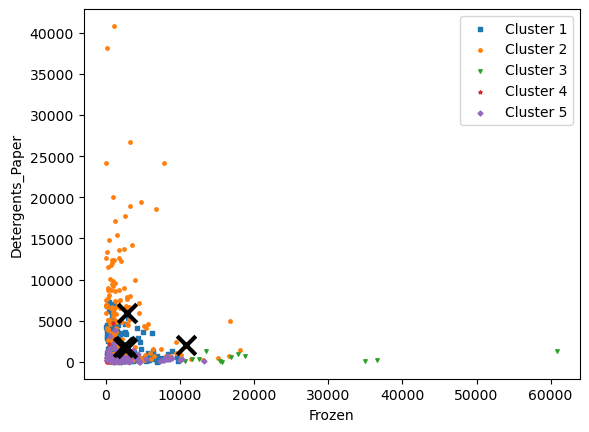

In [16]:
markers = ('s', 'o', 'v', '*', 'D', '+', 'p', '<', '>', 'x')
colors = ('C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9')

def plot_kmeans(pred, centroids, x_name, y_name, x_idx, y_idx, k,df):
    for i in range(0, k):
        plt.scatter(df[x_name].loc[pred == i], df[y_name].loc[pred == i], s=6,
                    c=colors[i], marker=markers[i], label='Cluster %d' % (i + 1))

    plt.scatter(centroids[:, x_idx], centroids[:, y_idx],
                marker='x', s=180, linewidths=3,
                color='k', zorder=10)

    plt.xlabel(x_name)
    plt.ylabel(y_name)
    plt.legend()
    plt.show()
    plt.close()
    
plot_kmeans(Gcluster_map, Gcentroids, 'Frozen', 'Detergents_Paper', 5, 6, 5,dataset)